# Transformer架构拆解
<div style="text-align: left;">
    <img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/06/Screenshot-from-2019-06-17-19-53-10.png" alt="alt text" width="350">
</div>

**作者 黄佳**

https://www.shenlanxueyuan.com/course/621 

- 生成式预训练语言模型：理论与实战

**现在开始！！！！**

## 模块1 - 缩放点积注意力

      

In [1]:
import numpy as np # 导入numpy库
import torch # 导入torch库
import torch.nn as nn # 导入torch.nn库
d_k = 64 # K(=Q)维度
d_v = 64 # V维度
# 定义缩放点积注意力类
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()        
    def forward(self, Q, K, V, attn_mask):        
        # 计算注意力分数（原始权重）
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
        # 使用注意力掩码，将attn_mask中值为1的位置的权重替换为极小值
        scores.masked_fill_(attn_mask, -1e9) 
        # 对注意力分数进行softmax
        weights = nn.Softmax(dim=-1)(scores)
        # 计算上下文向量（也就是注意力的输出）, 是上下文信息的紧凑表示
        context = torch.matmul(weights, V)
        return context, weights # 返回上下文向量和注意力分数

## 模块2 - 多头注意力类



In [2]:
# 定义多头注意力类
d_embedding = 512  # 嵌入向量的维度
n_heads = 8  # 多头注意力中头的个数
batch_size = 3 # 每一批的数据大小
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_embedding, d_k * n_heads) # Q的线性变换层
        self.W_K = nn.Linear(d_embedding, d_k * n_heads) # K的线性变换层
        self.W_V = nn.Linear(d_embedding, d_v * n_heads) # V的线性变换层
        self.linear = nn.Linear(n_heads * d_v, d_embedding) # 线性层
        self.layer_norm = nn.LayerNorm(d_embedding) # 层归一化
    def forward(self, Q, K, V, attn_mask):   
        residual, batch_size = Q, Q.size(0) # 保留残差连接
        # 将输入进行线性变换和重塑，以便后续处理
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)        
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)
        # 将注意力掩码复制到多头
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        # 使用缩放点积注意力计算上下文和注意力权重
        context, weights = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        # 重塑上下文向量并进行线性变换
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) 
        output = self.linear(context)
        # 与输入(Q)进行残差链接，并进行层归一化后输出
        output = self.layer_norm(output + residual)
        return output, weights # 返回层归一化的输出和注意力权重

## 模块3 - 逐位置前向传播网络



In [3]:
# 定义逐位置前向传播网络类
n_channels = 2048  # 网络中卷积层的维度
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        # 一维卷积层1，用于将输入映射到更高维度
        self.conv1 = nn.Conv1d(in_channels=d_embedding, out_channels=n_channels, kernel_size=1)
        # 一维卷积层2，用于将输入映射回原始维度
        self.conv2 = nn.Conv1d(in_channels=n_channels, out_channels=d_embedding, kernel_size=1)        
        self.layer_norm = nn.LayerNorm(d_embedding) # 层归一化

    def forward(self, inputs):  
        residual = inputs  # 保留残差连接
        # 在卷积层1后使用ReLU激活函数
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        # 使用卷积层2进行降维
        output = self.conv2(output).transpose(1, 2)
        # 与输入进行残差链接，并进行层归一化后输出
        output = self.layer_norm(output + residual)
        return output # 返回加入残差连接后层归一化的结果

## 模块4 - 正弦位置编码表


In [4]:
# 生成正弦位置编码表的函数，用于在Transformer中引入位置信息
def get_sin_enc_table(n_position, embedding_dim):
    # 根据位置和维度信息，初始化正弦位置编码表
    sinusoid_table = np.zeros((n_position, embedding_dim))    
    # 遍历所有位置和维度，计算角度值
    for pos_i in range(n_position):
        for hid_j in range(embedding_dim):
            angle = pos_i / np.power(10000, 2 * (hid_j // 2) / embedding_dim)
            sinusoid_table[pos_i, hid_j] = angle    
    # 计算正弦和余弦值
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i 偶数维
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1 奇数维    
    return torch.FloatTensor(sinusoid_table) # 返回正弦位置编码表

## 模块5 - 填充位注意力掩码



In [5]:
# 生成填充注意力掩码的函数，用于在多头自注意力计算中忽略填充部分
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # 生成布尔类型张量，<PAD>Token的编码值为0，掩码值为1(True)
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) 
    # 变形为与注意力分数相同形状的张量
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k) 
    return pad_attn_mask # 返回填充位置的注意力掩码

## 模块6/7 - 编码器层


In [6]:
# 定义编码器层类
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()        
        self.enc_self_attn = MultiHeadAttention() #多头自注意力层        
        self.pos_ffn = PoswiseFeedForwardNet() # 位置前馈神经网络层
    def forward(self, enc_inputs, enc_self_attn_mask):
        # 将相同的Q，K，V输入多头自注意力层
        enc_outputs, attn_weights = self.enc_self_attn(enc_inputs, enc_inputs,
                                               enc_inputs, enc_self_attn_mask)
        # 将多头自注意力outputs输入位置前馈神经网络层，得到编码器层的输出
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn_weights # 返回编码器层输出和每层编码器注意力权重

In [7]:
# 定义编码器类
n_layers = 6  # 设置Encoder的层数
class Encoder(nn.Module):
    def __init__(self, corpus):
        super(Encoder, self).__init__()        
        self.src_emb = nn.Embedding(len(corpus.src_vocab), d_embedding) # 词嵌入层
        self.pos_emb = nn.Embedding.from_pretrained( \
          get_sin_enc_table(corpus.src_len+1, d_embedding), freeze=True) # 位置嵌入层
        self.layers = nn.ModuleList(EncoderLayer() for _ in range(n_layers)) # 叠加多层
    def forward(self, enc_inputs):  
        # 创建一个从1到source_len的位置索引序列
        pos_indices = torch.arange(1, enc_inputs.size(1) + 1).unsqueeze(0).to(enc_inputs.device)     
        # 对输入进行词嵌入和位置嵌入相加 
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(pos_indices)        
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # 生成自注意力掩码
        enc_self_attn_weights = [] # 初始化 enc_self_attn_weights
        # 逐层通过编码器层，得到编码器最终输出及注意力权重列表
        for layer in self.layers:   
            enc_outputs, enc_self_attn_weight = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attn_weights.append(enc_self_attn_weight)
        return enc_outputs, enc_self_attn_weights # 返回编码器输出和编码器注意力权重

## 模块8 - 后续位注意力掩码



In [8]:
# 生成后续注意力掩码的函数，用于在多头自注意力计算中忽略未来信息
def get_attn_subsequent_mask(seq):
    # 获取输入序列的形状
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # 使用numpy创建一个上三角矩阵（triu = triangle upper）
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    # 将numpy数组转换为PyTorch张量，并将数据类型设置为byte（布尔值）
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask # 返回后续位置的注意力掩码

## 模块9/10 - 解码器层/解码器



In [9]:
# 定义解码器层类
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()        
        self.dec_self_attn = MultiHeadAttention() # 多头自注意力层       
        self.dec_enc_attn = MultiHeadAttention()  # 多头注意力层，连接编码器和解码器        
        self.pos_ffn = PoswiseFeedForwardNet() # 位置前馈神经网络层
    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        # 将相同的Q，K，V输入多头自注意力层
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, 
                                                        dec_inputs, dec_self_attn_mask)
        # 将解码器输出和编码器输出输入多头注意力层
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, 
                                                      enc_outputs, dec_enc_attn_mask)
        # 将编-解码注意力outputs输入位置前馈神经网络层, 返回解码器层的输出
        dec_outputs = self.pos_ffn(dec_outputs)
        # 返回解码器层输出，每层的自注意力和解码器-编码器注意力权重
        return dec_outputs, dec_self_attn, dec_enc_attn

In [10]:
# 定义解码器类
n_layers = 6  # 设置Decoder的层数
class Decoder(nn.Module):
    def __init__(self, corpus):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(len(corpus.tgt_vocab), d_embedding) # 词嵌入层
        self.pos_emb = nn.Embedding.from_pretrained( \
           get_sin_enc_table(corpus.tgt_len+1, d_embedding), freeze=True) # 位置嵌入层        
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)]) # 叠加多层
    def forward(self, dec_inputs, enc_inputs, enc_outputs): 
        # 创建一个从1到source_len的位置索引序列
        pos_indices = torch.arange(1, dec_inputs.size(1) + 1).unsqueeze(0).to(dec_inputs.device)     
        # 对输入进行词嵌入和位置嵌入相加
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos_indices)
        # 生成解码器自注意力掩码和解码器-编码器注意力掩码
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs) # 填充位掩码
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs) # 后续位掩码
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask.to(device) \
                                       + dec_self_attn_subsequent_mask.to(device)), 0) 
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # 解码器-编码器掩码
        dec_self_attns, dec_enc_attns = [], [] # 初始化 dec_self_attns, dec_enc_attns
        # 逐层通过解码器层，得到解码器最终输出及注意力权重列表
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, 
                                                             dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        # 返回解码器输出，解码器自注意力和解码器-编码器注意力权重
        return dec_outputs, dec_self_attns, dec_enc_attns

## Transformer来了!!


In [11]:
# 定义Transformer模型
class Transformer(nn.Module):
    def __init__(self, corpus):
        super(Transformer, self).__init__()        
        self.encoder = Encoder(corpus) # 初始化编码器实例        
        self.decoder = Decoder(corpus) # 初始化解码器实例
        # 定义线性投影层，将解码器输出转换为目标词汇表大小的概率分布
        self.projection = nn.Linear(d_embedding, len(corpus.tgt_vocab), bias=False)
    def forward(self, enc_inputs, dec_inputs):
        # 将输入传递给编码器，并获取编码器输出和自注意力权重
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # 将解码器输入、编码器输入输出传递给解码器，获取解码器输出、自注意力权重和编-解码器注意力权重
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # 将解码器输出传递给投影层，生成目标词汇表大小的概率分布
        dec_logits = self.projection(dec_outputs)  
        # 返回逻辑值(原始预测结果),编码器自注意力权重，解码器自注意力权重，解-编码器注意力权重
        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns

In [12]:
from collections import Counter # 导入Counter类
# 定义TranslationCorpus类
class TranslationCorpus:
    def __init__(self, sentences):
        self.sentences = sentences
        # 计算源语言和目标语言的最大句子长度，并分别加1和2以容纳填充符和特殊符号
        self.src_len = max(len(sentence[0].split()) for sentence in sentences) + 1
        self.tgt_len = max(len(sentence[1].split()) for sentence in sentences) + 2
        # 创建源语言和目标语言的词汇表
        self.src_vocab, self.tgt_vocab = self.create_vocabularies()
        # 创建索引到单词的映射
        self.src_idx2word = {v: k for k, v in self.src_vocab.items()}
        self.tgt_idx2word = {v: k for k, v in self.tgt_vocab.items()}
    # 创建词汇表的函数
    def create_vocabularies(self):
        # 统计源语言和目标语言的单词频率
        src_counter = Counter(word for sentence in self.sentences for word in sentence[0].split())
        tgt_counter = Counter(word for sentence in self.sentences for word in sentence[1].split())        
        # 创建源语言和目标语言的词汇表，并为每个单词分配一个唯一的索引
        src_vocab = {'<pad>': 0, **{word: i+1 for i, word in enumerate(src_counter)}}
        tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, 
                     **{word: i+3 for i, word in enumerate(tgt_counter)}}        
        return src_vocab, tgt_vocab
    # 创建批次数据的函数
    def make_batch(self, batch_size, test_batch=False):
        input_batch, output_batch, target_batch = [], [], []
        # 随机选择句子索引
        sentence_indices = torch.randperm(len(self.sentences))[:batch_size]
        for index in sentence_indices:
            src_sentence, tgt_sentence = self.sentences[index]
            # 将源语言和目标语言的句子转换为索引序列
            src_seq = [self.src_vocab[word] for word in src_sentence.split()]
            tgt_seq = [self.tgt_vocab['<sos>']] + [self.tgt_vocab[word] \
                         for word in tgt_sentence.split()] + [self.tgt_vocab['<eos>']]            
            # 对源语言和目标语言的序列进行填充
            src_seq += [self.src_vocab['<pad>']] * (self.src_len - len(src_seq))
            tgt_seq += [self.tgt_vocab['<pad>']] * (self.tgt_len - len(tgt_seq))            
            # 将处理好的序列添加到批次中
            input_batch.append(src_seq)
            output_batch.append([self.tgt_vocab['<sos>']] + ([self.tgt_vocab['<pad>']] * \
                                    (self.tgt_len - 2)) if test_batch else tgt_seq[:-1])
            target_batch.append(tgt_seq[1:])        
        # 将批次转换为LongTensor类型
        input_batch = torch.LongTensor(input_batch)
        output_batch = torch.LongTensor(output_batch)
        target_batch = torch.LongTensor(target_batch)            
        return input_batch, output_batch, target_batch

In [13]:
# 准备一些中译英语料
sentences = [
    ['咖哥 喜欢 小冰', 'KaGe likes XiaoBing'],
    ['我 爱 学习 人工智能', 'I love studying AI'],
    ['深度学习 改变 世界', 'Deep learning YYDS'],
    ['自然语言处理 很 强大', 'NLP is powerful'],
    ['神经网络 非常 复杂', 'Neural-networks are complex'] ]
corpus = TranslationCorpus(sentences) # 创建语料库类实例

import torch.optim as optim # 导入优化器
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(corpus).to(device) # 创建模型实例
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0001) # 优化器
epochs = 10 # 训练轮次
for epoch in range(100): # 训练100轮
    optimizer.zero_grad() # 梯度清零
    # # Generate a batch of input, output, and target sequences
    enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size) # 创建训练数据        
    enc_inputs, dec_inputs, target_batch = enc_inputs.to(device), dec_inputs.to(device), target_batch.to(device)
    outputs, _, _, _ = model(enc_inputs, dec_inputs) # 获取模型输出 
    loss = criterion(outputs.view(-1, len(corpus.tgt_vocab)), target_batch.view(-1)) # 计算损失
    if (epoch + 1) % 20 == 0: # 打印损失
        print(f"Epoch: {epoch + 1:04d} cost = {loss:.6f}")
    loss.backward()# 反向传播        
    optimizer.step()# 更新参数

Epoch: 0020 cost = 0.016888
Epoch: 0040 cost = 0.003108
Epoch: 0060 cost = 0.001789
Epoch: 0080 cost = 0.001178
Epoch: 0100 cost = 0.000919


In [14]:
# 创建一个大小为1的批次，目标语言序列dec_inputs在测试阶段，仅包含句子开始符号<sos>
enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size=1,test_batch=True) 
enc_inputs, dec_inputs, target_batch = enc_inputs.to(device), dec_inputs.to(device), target_batch.to(device)
print("编码器输入:", enc_inputs) # 打印编码器输入
print("解码器输入:", dec_inputs) # 打印解码器输入
print("目标数据:", target_batch) # 打印目标数据
predict, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs) # 用模型进行翻译
predict = predict.view(-1, len(corpus.tgt_vocab)) # 将预测结果维度重塑
predict = predict.data.max(1, keepdim=True)[1] # 找到每个位置概率最大的词汇的索引
# 解码预测的输出，将所预测的目标句子中的索引转换为单词
translated_sentence = [corpus.tgt_idx2word[idx.item()] for idx in predict.squeeze()]
# 将输入的源语言句子中的索引转换为单词
input_sentence = ' '.join([corpus.src_idx2word[idx.item()] for idx in enc_inputs[0]])
print(input_sentence, '->', translated_sentence) # 打印原始句子和翻译后的句子

编码器输入: tensor([[1, 2, 3, 0, 0]])
解码器输入: tensor([[1, 0, 0, 0, 0]])
目标数据: tensor([[3, 4, 5, 2, 0]])
咖哥 喜欢 小冰 <pad> <pad> -> ['KaGe', 'KaGe', 'KaGe', 'KaGe', 'KaGe']


first head of last state enc_self_attns


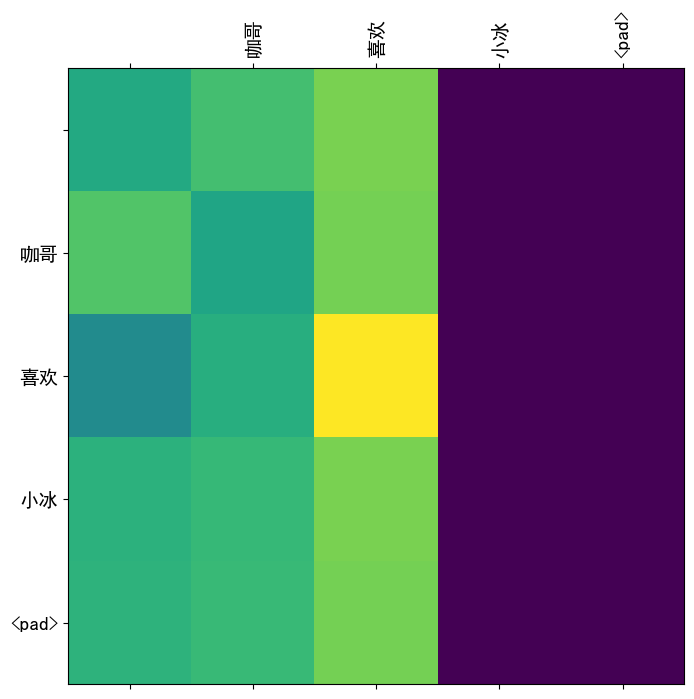

first head of last state dec_self_attns


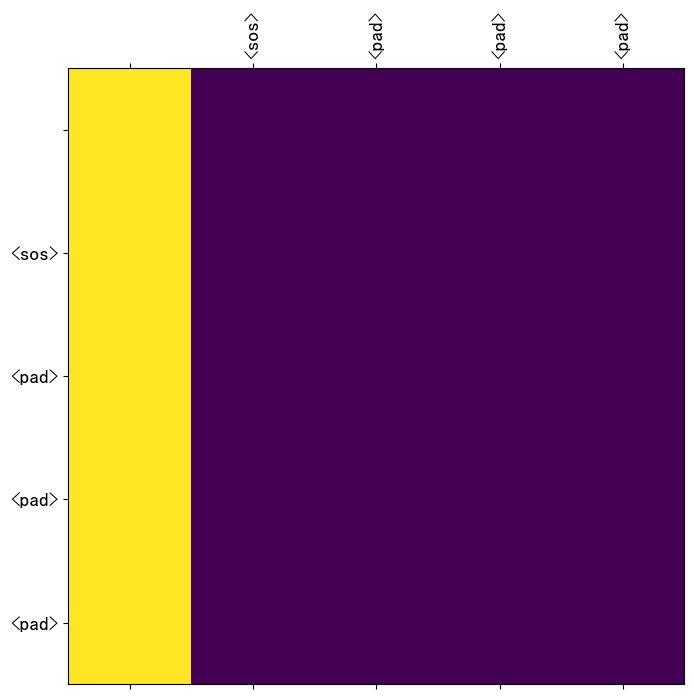

first head of last state dec_enc_attns


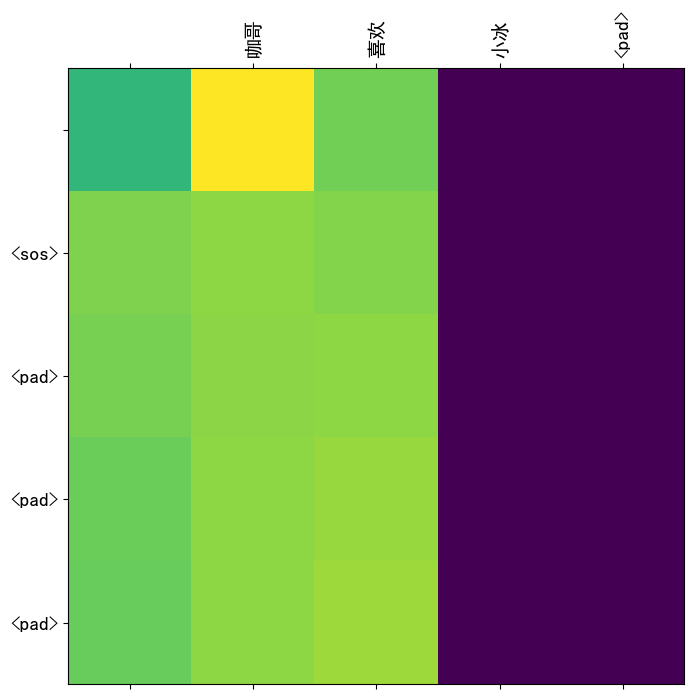

In [15]:
import matplotlib.pyplot as plt # 导入matplotlib
from matplotlib.ticker import FixedLocator # # 导入FixedLocator
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
def showgraph(attn, src_input, tgt_input, attention_type='enc'):
    attn = attn[-1].squeeze(0)[0]  # 提取最后一层注意力权重的第一个头
    attn = attn.squeeze(0).cpu().data.numpy()  # 去除冗余维度并转换为numpy数组
    fig = plt.figure(figsize=(n_heads, n_heads))  # 创建一个新的图形
    ax = fig.add_subplot(1, 1, 1)  # 添加一个子图
    ax.matshow(attn, cmap='viridis')  # 绘制注意力权重矩阵    
    if attention_type == 'enc':
        src_labels = [''] + [corpus.src_idx2word[idx.item()] for idx in src_input]
        tgt_labels = src_labels
    elif attention_type == 'dec':
        src_labels = [''] + [corpus.tgt_idx2word[idx.item()] for idx in tgt_input]
        tgt_labels = src_labels
    elif attention_type == 'dec_enc':
        src_labels = [''] + [corpus.src_idx2word[idx.item()] for idx in src_input]
        tgt_labels = [''] + [corpus.tgt_idx2word[idx.item()] for idx in tgt_input]
    ax.xaxis.set_major_locator(FixedLocator(range(len(src_labels)))) # 设置FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(range(len(tgt_labels)))) # 设置FixedLocator
    ax.set_xticklabels(src_labels, fontdict={'fontsize': 14}, rotation=90)  # 设置x轴标签
    ax.set_yticklabels(tgt_labels, fontdict={'fontsize': 14})  # 设置y轴标签
    plt.show()  # 显示图形
print('first head of last state enc_self_attns')
showgraph(enc_self_attns, enc_inputs[0], enc_inputs[0], attention_type='enc')  # 显示编码器自注意力权重
print('first head of last state dec_self_attns')
showgraph(dec_self_attns, dec_inputs[0], dec_inputs[0], attention_type='dec')  # 显示解码器自注意力权重
print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns, enc_inputs[0], dec_inputs[0], attention_type='dec_enc')  # 解码器-编码器注意力权重

first head of last state enc_self_attns


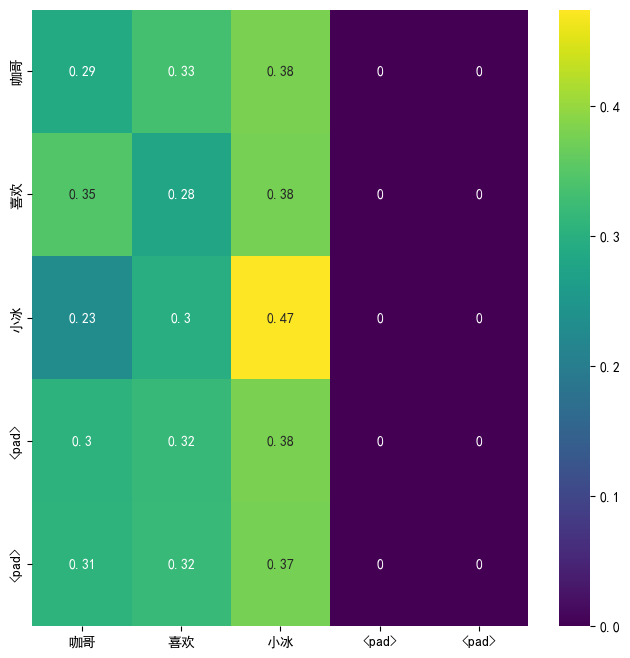

In [16]:
import seaborn as sns # 导入
# 定义显示注意力权重的函数
def showgraph(attn, src_input, head_idx=0):
    # 选择一个特定的头并删除额外的维度
    attn = attn[-1].squeeze(0)[head_idx].cpu().data.numpy() 
    plt.figure(figsize=(n_heads, n_heads)) # 创建一个新的图形   
    # 将输入索引转换为单词标签
    src_labels = [corpus.src_idx2word[idx.item()] for idx in src_input]    
    # 使用seaborn库绘制热力图
    sns.heatmap(attn, cmap='viridis', 
                xticklabels=src_labels, 
                yticklabels=src_labels, 
                annot=True)      
    plt.show()# 显示图形
# 显示编码器自注意力权重的第一个头的最后一层
print('first head of last state enc_self_attns')
showgraph(enc_self_attns, enc_inputs[0], 0)